In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

`torchvision`의 `Image Transform` 에 대하여 생소하다면 **다음의 링크를 참고**해 주시기 바랍니다.

- [torchvision의 transform으로 이미지 정규화하기(평균, 표준편차를 계산하여 적용)](https://teddylee777.github.io/pytorch/torchvision-transform)
- [PyTorch 이미지 데이터셋(Image Dataset) 구성에 관한 거의 모든 것!](https://teddylee777.github.io/pytorch/dataset-dataloader)

`개와 고양이` 데이터셋을 다운로드 받아서 `tmp` 폴더에 압축을 풀어 줍니다.

[데이터셋 출처: 캐글, 마이크로소프트](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip)

하단의 `code snippets`는 corrupted 된 이미지를 확인하고 제거하기 위한 코드 입니다. `Cats vs Dogs`데이터셋에도 원인 모를 이유 때문에 이미지 데이터가 corrupt된 파일이 2개가 존재합니다. 이렇게 corrupt 된 이미지를 `DataLoader`로 로드시 에러가 발생하기 때문에 전처리 때 미리 제거하도록 하겠습니다.

## 데이터셋 다운로드 및 압축 해제

In [2]:
# 이미지 데이터셋 다운로드
import urllib.request
import zipfile
import glob
import os
import random
from PIL import Image, UnidentifiedImageError,ImageFile

SEED = 123

In [26]:
# 데이터셋을 다운로드 합니다.
url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
urllib.request.urlretrieve(url, 'cats_and_dogs.zip')

('cats_and_dogs.zip', <http.client.HTTPMessage at 0x7f98e2f911d0>)

In [38]:
# 다운로드 후 tmp 폴더에 압축을 해제 합니다.
local_zip = 'cats_and_dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

다운로드 받은 이미지에 대하여 정규성 검증을 수행합니다. (실제 Corrupted된 이미지가 2건이 있습니다.)

In [112]:
# 잘린 이미지 Load 시 경고 출력 안함
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [113]:
# 이미지 Validation을 수행하고 Validate 여부를 return 합니다.
def validate_image(filepath):
    try:
        # PIL.Image로 이미지 데이터를 로드하려고 시도합니다.
        img = Image.open(filepath).convert('RGB')
        img.load()
    except UnidentifiedImageError: # corrupt 된 이미지는 해당 에러를 출력합니다.
        print(f'Corrupted Image is found at: {filepath}')
        return False
    except (IOError, OSError): # Truncated (잘린) 이미지에 대한 에러를 출력합니다.
        print(f'Truncated Image is found at: {filepath}')
        return False
    else:
        return True

In [114]:
# image 데이터셋 root 폴더
root = 'tmp/PetImages' 

dirs = os.listdir(root)

for dir_ in dirs:
    folder_path = os.path.join(root, dir_)
    files = os.listdir(folder_path)
    
    images = [os.path.join(folder_path, f) for f in files]
    for img in images:
        valid = validate_image(img)
        if not valid:
            # corrupted 된 이미지 제거
            os.remove(img)

folders = glob.glob('tmp/PetImages/*')
print(folders)

['tmp/PetImages/Dog', 'tmp/PetImages/Cat']


## Train / Test 셋 분할

In [7]:
# train: test ratio. 0.2로 설정시 test set의 비율은 20%로 설정
test_size = 0.2

# train / test 셋의 파일을 나눕니다.
train_images = []
test_images = []

for folder in folders:
    label = os.path.basename(folder)
    files = sorted(glob.glob(folder + '/*'))

    # 각 Label별 이미지 데이터셋 셔플
    random.seed(SEED)
    random.shuffle(files)

    idx = int(len(files) * test_size)
    train = files[:-idx]
    test = files[-idx:]

    train_images.extend(train)
    test_images.extend(test)

# train, test 전체 이미지 셔플
random.shuffle(train_images)
random.shuffle(test_images)

# Class to Index 생성. {'Dog': 0, 'Cat': 1}
class_to_idx = {os.path.basename(f):idx for idx, f in enumerate(folders)}

# Label 생성
train_labels = [f.split('/')[-2] for f in train_images]
test_labels = [f.split('/')[-2] for f in test_images]

print('==='*10)
print(f'train images: {len(train_images)}')
print(f'train labels: {len(train_labels)}')
print(f'test images: {len(test_images)}')
print(f'test labels: {len(test_labels)}')

train images: 20000
train labels: 20000
test images: 4998
test labels: 4998


## Dataset 을 상속 받아 CustomImageDataset 구성

In [44]:
class CustomImageDataset(Dataset):
    def __init__(self, files, labels, class_to_idx, transform):
        super(CustomImageDataset, self).__init__()
        self.files = files
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.transform = transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        # file 경로
        file = self.files[idx]
        # PIL.Image로 이미지 로드
        img = Image.open(file).convert('RGB')
        # transform 적용
        img = self.transform(img)
        # label 생성
        lbl = self.class_to_idx[self.labels[idx]]
        # image, label return
        return img, lbl

`Image Augmentation`을 적용 합니다.

- [PyTorch Image Augmentation 도큐먼트](https://pytorch.org/vision/stable/transforms.html)

In [45]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),          # 개와 고양이 사진 파일의 크기가 다르므로, Resize로 맞춰줍니다.
    transforms.CenterCrop((224, 224)),      # 중앙 Crop
    transforms.RandomHorizontalFlip(0.5),   # 50% 확률로 Horizontal Flip
    transforms.ToTensor(), 
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 이미지 정규화
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),      # 개와 고양이 사진 파일의 크기가 다르므로, Resize로 맞춰줍니다.
    transforms.ToTensor(), 
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 이미지 정규화
])

In [46]:
# train, test 데이터셋 생성
train_dataset = CustomImageDataset(train_images, train_labels, class_to_idx, train_transform)
test_dataset = CustomImageDataset(test_images, test_labels, class_to_idx, test_transform)

`CustomImageDataset`은 `Dataset` 클래스를 상속받았기 때문에 DataLoader 안에 바로 대입할 수 있습니다.

In [47]:
# train, test 데이터 로더 생성 => 모델 학습시 입력하는 데이터셋
train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True,
                          num_workers=8
                         )

test_loader = DataLoader(test_dataset, 
                         batch_size=32, 
                         shuffle=True,
                         num_workers=8
                        )

In [48]:
# 1개의 배치를 추출합니다.
images, labels = next(iter(train_loader))

In [49]:
# 이미지의 shape을 확인합니다. 224 X 224 RGB 이미지 임을 확인합니다.
images[0].shape

torch.Size([3, 224, 224])

`개와 고양이` 데이터셋 시각화

- 총 2개의 class(강아지/고양이)로 구성된  사진 파일입니다.

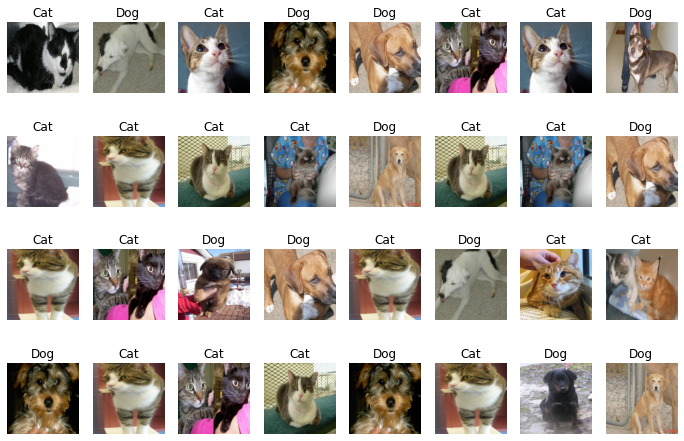

In [14]:
import matplotlib.pyplot as plt

# ImageFolder의 속성 값인 class_to_idx를 할당
labels_map = {v:k for k, v in train_dataset.class_to_idx.items()}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 4

# 이미지를 출력합니다. RGB 이미지로 구성되어 있습니다.
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # 본래 이미지의 shape은 (3, 300, 300) 입니다.
    # 이를 imshow() 함수로 이미지 시각화 하기 위하여 (300, 300, 3)으로 shape 변경을 한 후 시각화합니다.
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

## pre-trained 모델 로드

CUDA 설정이 되어 있다면 `cuda`를! 그렇지 않다면 `cpu`로 학습합니다.

(제 PC에는 GPU가 2대 있어서 `cuda:0`로 GPU 장비의 index를 지정해 주었습니다. 만약 다른 장비를 사용하고 싶다면 `cuda:1` 이런식으로 지정해 주면 됩니다)

In [15]:
# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


**pre-trained model**을 fine tuning 하여 Image Classification을 구현하도록 하겠습니다.

In [115]:
from torchvision import models # pretrained 모델을 가져오기 위한 import

# ResNet101 모델 생성
model = models.resnet101(pretrained=True) # pretrained=True 로 설정, pretrained=False로 설정되었을 경우 가중치는 가져오지 않습니다.

그 밖의 활용 가능한 pretrained 모델

- `models.alexnet(pregrained=True)`      # AlexNet
- `models.vgg16(pretrained=True)`        # VGG16
- `models.resnet18(pretrained=True)`     # ResNet18
- `models.inception_v3(pretrained=True)` # Inception_V3

In [116]:
# 가중치를 Freeze 하여 학습시 업데이트가 일어나지 않도록 설정합니다.
for param in model.parameters():
    param.requires_grad = False  # 가중치 Freeze

In [117]:
import torch.nn as nn


# Fully-Connected Layer를 Sequential로 생성하여 VGG pretrained 모델의 'Classifier'에 연결합니다.
fc = nn.Sequential(
    nn.Linear(2048, 256), # VGG16 모델의 features의 출력이 7X7, 512장 이기 때문에 in_features=7*7*512 로 설정합니다.
    nn.ReLU(), 
    nn.Linear(256, 64), 
    nn.ReLU(), 
    nn.Linear(64, 2), # Cats vs Dogs 이진 분류이기 때문에 2로 out_features=2로 설정합니다.
)

In [118]:
model.fc = fc
model.to(device)
# 모델의 구조도 출력
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [119]:
import torch.optim as optim

In [120]:
# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

## 훈련(Train)

In [121]:
from tqdm import tqdm  # Progress Bar 출력

In [122]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0
    
    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)
    
    # mini-batch 학습을 시작합니다.
    for img, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        img, lbl = img.to(device), lbl.to(device)
        
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()
        
        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(img)
        
        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()
        
        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()
        
        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * img.size(0)
        
    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

## 평가(Evaluate)

In [123]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0
        
        # 배치별 evaluation을 진행합니다.
        for img, lbl in data_loader:
            # device에 데이터를 올립니다.
            img, lbl = img.to(device), lbl.to(device)
            
            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(img)
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * img.size(0)
        
        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)
        
        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

## 모델 훈련(training) & 검증

In [124]:
# 최대 Epoch을 지정합니다.
num_epochs = 10
model_name = 'vgg16-pretrained'

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)   
    
    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), f'{model_name}.pth')
    
    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

100% 625/625 [00:29<00:00, 21.53it/s]


[INFO] val_loss has been improved from inf to 0.03903. Saving Model!
epoch 01, loss: 0.07958, acc: 0.96995, val_loss: 0.03903, val_accuracy: 0.98599


100% 625/625 [00:29<00:00, 21.49it/s]


epoch 02, loss: 0.05394, acc: 0.98070, val_loss: 0.05530, val_accuracy: 0.97739


100% 625/625 [00:29<00:00, 21.38it/s]


epoch 03, loss: 0.04938, acc: 0.98265, val_loss: 0.04420, val_accuracy: 0.98419


100% 625/625 [00:29<00:00, 21.34it/s]


epoch 04, loss: 0.04980, acc: 0.98175, val_loss: 0.04602, val_accuracy: 0.98019


100% 625/625 [00:29<00:00, 21.26it/s]


[INFO] val_loss has been improved from 0.03903 to 0.03703. Saving Model!
epoch 05, loss: 0.04326, acc: 0.98340, val_loss: 0.03703, val_accuracy: 0.98840


100% 625/625 [00:29<00:00, 21.30it/s]


epoch 06, loss: 0.03946, acc: 0.98560, val_loss: 0.03915, val_accuracy: 0.98579


100% 625/625 [00:29<00:00, 21.27it/s]


[INFO] val_loss has been improved from 0.03703 to 0.03520. Saving Model!
epoch 07, loss: 0.03919, acc: 0.98560, val_loss: 0.03520, val_accuracy: 0.98780


100% 625/625 [00:29<00:00, 21.26it/s]


epoch 08, loss: 0.03481, acc: 0.98605, val_loss: 0.03767, val_accuracy: 0.98619


100% 625/625 [00:29<00:00, 21.30it/s]


[INFO] val_loss has been improved from 0.03520 to 0.03397. Saving Model!
epoch 09, loss: 0.04022, acc: 0.98525, val_loss: 0.03397, val_accuracy: 0.98840


100% 625/625 [00:29<00:00, 21.22it/s]


epoch 10, loss: 0.03700, acc: 0.98630, val_loss: 0.03592, val_accuracy: 0.98719


## 저장한 가중치 로드 후 검증 성능 측정

In [125]:
# 모델에 저장한 가중치를 로드합니다.
model.load_state_dict(torch.load(f'{model_name}.pth'))

<All keys matched successfully>

In [126]:
# 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
final_loss, final_acc = model_evaluate(model, test_loader, loss_fn, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')

evaluation loss: 0.03397, evaluation accuracy: 0.98840
